In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [84]:
data = pd.read_csv("electricity.csv", parse_dates = ["datetime"])
data.head()

,datetime,energy_kwh
0,2020-01-01 00:00:00,2.14
1,2020-01-01 01:00:00,2.05
2,2020-01-01 02:00:00,1.98
3,2020-01-01 03:00:00,1.92
4,2020-01-01 04:00:00,1.87


In [85]:
data["hour"] = data["datetime"].dt.hour
data["day"] = data["datetime"].dt.day
data["weekday"] = data["datetime"].dt.weekday
data["month"] = data["datetime"].dt.month

In [86]:
data["lag1"] = data["energy_kwh"].shift(1)
data["lag2"] = data["energy_kwh"].shift(2)
data["lag3"] = data["energy_kwh"].shift(3)

In [87]:
data["rolling_mean"] = data["energy_kwh"].rolling(window=3).mean()
data = data.dropna()

In [88]:
data

,datetime,energy_kwh,hour,day,weekday,month,lag1,lag2,lag3,rolling_mean
3,2020-01-01 03:00:00,1.92,3,1,2,1,1.98,2.05,2.14,1.983333
4,2020-01-01 04:00:00,1.87,4,1,2,1,1.92,1.98,2.05,1.923333
5,2020-01-01 05:00:00,1.90,5,1,2,1,1.87,1.92,1.98,1.896667
6,2020-01-01 06:00:00,2.10,6,1,2,1,1.90,1.87,1.92,1.956667
7,2020-01-01 07:00:00,2.45,7,1,2,1,2.10,1.90,1.87,2.150000
...,...,...,...,...,...,...,...,...,...,...
67,2020-01-03 19:00:00,4.10,19,3,4,1,3.88,3.55,3.42,3.843333
68,2020-01-03 20:00:00,3.95,20,3,4,1,4.10,3.88,3.55,3.976667
69,2020-01-03 21:00:00,3.72,21,3,4,1,3.95,4.10,3.88,3.923333
70,2020-01-03 22:00:00,3.35,22,3,4,1,3.72,3.95,4.10,3.673333


In [89]:
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

In [90]:
features = ["hour", "day", "weekday", "month", "lag1", "lag2", "lag3", "rolling_mean"]
target = "energy_kwh"

In [91]:
X_train = train[features]
X_test = test[features]

y_train = train[target]
y_test = test[target]

In [92]:
pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge())
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', Ridge())])

In [93]:
y_pred = pipeline.predict(X_test)

In [94]:
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.10850384141452131


In [95]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.016440815132395686


In [96]:
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

R2 Score: 0.8071435551356438


In [97]:
param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error"
)

In [98]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Ridge())]),
             param_grid={'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_absolute_error')

In [99]:
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Params: {'model__alpha': 0.001}
Best CV Score: -0.000807593689845033


In [100]:
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

In [101]:
mae_best = mean_absolute_error(y_test, y_pred_best)
print("Tuned Mean Absolute Error:", mae_best)

Tuned Mean Absolute Error: 0.0005671407848023399


In [102]:
mse_best = mean_squared_error(y_test, y_pred_best)
print("Tuned Mean Squared Error:", mse_best)

Tuned Mean Squared Error: 4.725905571716559e-07


In [103]:
r2_best = r2_score(y_test, y_pred_best)
print("Tuned R2 Score:", r2_best)

Tuned R2 Score: 0.9999944563493964


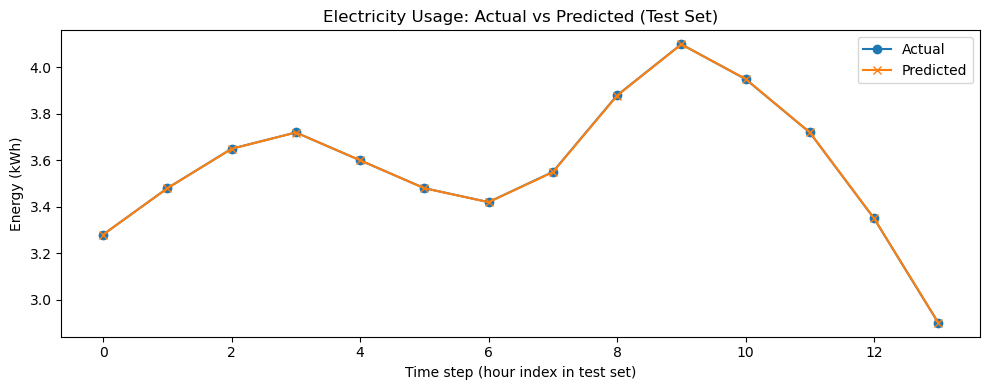

In [104]:
plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred_best, label="Predicted", marker='x')
plt.legend()
plt.title("Electricity Usage: Actual vs Predicted (Test Set)")
plt.xlabel("Time step (hour index in test set)")
plt.ylabel("Energy (kWh)")
plt.tight_layout()
plt.show()


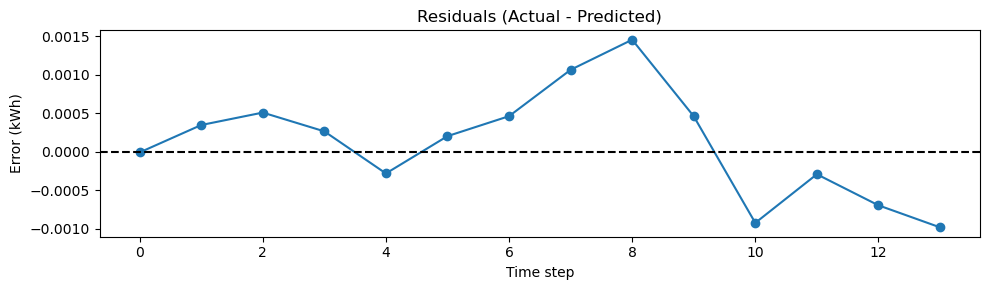

In [105]:
residuals = y_test.values - y_pred_best

plt.figure(figsize=(10, 3))
plt.plot(residuals, marker='o')
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Time step")
plt.ylabel("Error (kWh)")
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


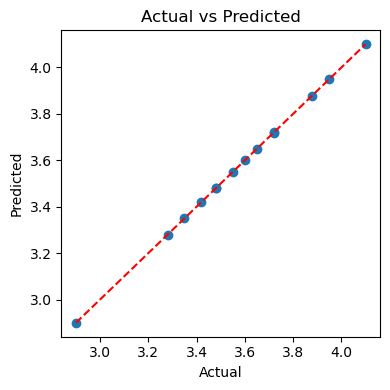

In [106]:
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_best)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')  # ideal line
plt.tight_layout()
plt.show()

In [107]:
models = {
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=0.001))  # from your tuning
    ]),
    "RandomForest": Pipeline([
        ("model", RandomForestRegressor(
            n_estimators=200,
            random_state=42
        ))
    ]),
    "GradientBoosting": Pipeline([
        ("model", GradientBoostingRegressor(
            n_estimators=200,
            random_state=42
        ))
    ])
}

results = {}

In [110]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_m = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred_m)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_m))
    r2 = r2_score(y_test, y_pred_m)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

results

{'Ridge': {'MAE': 0.0005671407848023399,
  'RMSE': np.float64(0.0006874522217373771),
  'R2': 0.9999944563493964},
 'RandomForest': {'MAE': 0.07978928571428281,
  'RMSE': np.float64(0.10441476274249273),
  'R2': 0.8721105785574114},
 'GradientBoosting': {'MAE': 0.07483679366599698,
  'RMSE': np.float64(0.09912722135515235),
  'R2': 0.8847352066776608}}

In [111]:
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  MAE:  {metrics['MAE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R2:   {metrics['R2']:.4f}")
    print()

Ridge:
  MAE:  0.0006
  RMSE: 0.0007
  R2:   1.0000

RandomForest:
  MAE:  0.0798
  RMSE: 0.1044
  R2:   0.8721

GradientBoosting:
  MAE:  0.0748
  RMSE: 0.0991
  R2:   0.8847



In [112]:
import joblib

joblib.dump(best_model, "electricity_forecaster.pkl")

['electricity_forecaster.pkl']